In [1]:
import awkward as ak
import numpy as np
import time
import coffea
print(coffea.__version__)
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
files = "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_300to470_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/120000/3788BBD3-3B70-BE48-B01A-4FA395E1E0B6.root"
#ADD MORE PT BINS
#"root://cmseos.fnal.gov//store/user/hats/2021/JEC/RunIISummer19UL17NanoAOD_QCD_Pt-15to7000_NANOAODSIM_JMECustomTuples.root"
events = NanoEventsFactory.from_root(files, schemaclass=NanoAODSchema).events()

0.7.9


In [4]:
from coffea import processor, hist

class TriJetHists(processor.ProcessorABC):
    def __init__(self):
        dataset_cats = hist.Cat("dataset", "Dataset")
        jet_cats = hist.Cat("jetNumb", "Jet")
        parton_cats = hist.Cat("parton_flav", "Parton Flavour")
        mass_bins = hist.Bin("mass", "Jet Mass", 60, 0, 120)
        self._histos = processor.dict_accumulator({
        'mass1':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'mass2':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'mass3':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'genmass1':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'genmass2':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'genmass3':hist.Hist(
            "Events", jet_cats,
            mass_bins,
        ),
        'mass3_g':hist.Hist(
            "Events", parton_cats,
            mass_bins,
        ),
        'mass3_uds':hist.Hist(
            "Events", parton_cats,
            mass_bins,
        ),
        'mass3_c':hist.Hist(
            "Events", parton_cats,
            mass_bins,
        ),
        'mass3_b':hist.Hist(
            "Events", parton_cats,
            mass_bins,
        ),
        'weights':hist.Hist(
            "Events",
            dataset_cats,
            hist.Bin("weights", "gen weights", 60, 0, 1),
        )})
    
    @property
    def accumulator(self):
        return self._histos
    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        trijetevents = events[
            (ak.num(events.FatJet) >= 3) & (ak.num(events.GenJetAK8) >= 3) #add pt > 100 here???
        ]
        
        #get leading 3 jets
        jet1 = trijetevents.FatJet[:, 0]
        jet2 = trijetevents.FatJet[:, 1]
        jet3 = trijetevents.FatJet[:, 2]
        
        print("Softest jets after >3 selection", len(jet3))
        
        
        #calculate dphi_min
        dphi12 = np.abs(jet1.delta_phi(jet2))
        dphi13 = np.abs(jet1.delta_phi(jet3))
        dphi23 = np.abs(jet2.delta_phi(jet3))
        
        dphi_min = np.amin([dphi12, dphi13, dphi23], axis = 0)

        #do the same for gen
        
        #do same for gen; jets might not be same order reco and gen
        genjet1 = trijetevents.GenJetAK8[:,0]
        genjet2 = trijetevents.GenJetAK8[:,1]
        genjet3 = trijetevents.GenJetAK8[:,2]
        
        dphi12_gen = np.abs(genjet1.delta_phi(genjet2))
        dphi13_gen = np.abs(genjet1.delta_phi(genjet3))
        dphi23_gen = np.abs(genjet2.delta_phi(genjet3))
        
        dphimin_gen = np.amin([dphi12_gen, dphi13_gen, dphi23_gen], axis = 0)
        
        #apply dphi gen and reco selection
        trijetevents = trijetevents[(dphimin_gen > 1.0) & (dphi_min > 1.0)]
        #match jets
        matched1 = ~ak.is_none(trijetevents.FatJet[:,0].matched_gen)
        matched2 = ~ak.is_none(trijetevents.FatJet[:,1].matched_gen)
        matched3 = ~ak.is_none(trijetevents.FatJet[:,2].matched_gen)
        fake_jets = trijetevents.FatJet[ak.is_none(trijetevents.FatJet.matched_gen)]
        jet1 = trijetevents.FatJet[:,0][matched1]
        jet2 = trijetevents.FatJet[:,1][matched2]
        jet3 = trijetevents.FatJet[:,2][matched3]
        
        genjet1 = jet1.matched_gen
        genjet2 = jet2.matched_gen
        genjet3 = jet3.matched_gen

        print("Softest jets after dphi selection and matching", len(jet3))
        
        #flavour --> 21 is gluon
        jet3_g = jet3[np.abs(genjet3.partonFlavour) == 21]
        jet3_uds = jet3[np.abs(genjet3.partonFlavour) < 4]
        jet3_c = jet3[np.abs(genjet3.partonFlavour) == 4]
        jet3_b = jet3[np.abs(genjet3.partonFlavour) == 5]
        
        print("Btag discr. for gluon jets:", jet3_g.btagCSVV2)
        
        print("Gluon purity of third jet for basic selection: ", len(jet3_g)/len(jet3))
        
        #now require leading two jets b-tagged w/ loose discr.
        trijetevents_bbloose = trijetevents[(trijetevents.FatJet[:,0].btagCSVV2 >= 0.460) & (trijetevents.FatJet[:,1].btagCSVV2 >= 0.460)]
        matched3_btag = ~ak.is_none(trijetevents_bbloose.FatJet[:,2].matched_gen)
        jet3_bbloose = trijetevents_bbloose.FatJet[:,2][matched3_btag]
        print("Gluon purity of third jet for bb loose selection: ", len(jet3_bbloose[np.abs(jet3_bbloose.matched_gen.partonFlavour) == 21])/len(jet3_bbloose))
    
        #now require leading two jets b-tagged w/ medium discr.
        trijetevents_bbmed = trijetevents[(trijetevents.FatJet[:,0].btagCSVV2 >= 0.80) & (trijetevents.FatJet[:,1].btagCSVV2 >= 0.80)]
        matched3_btag = ~ak.is_none(trijetevents_bbmed.FatJet[:,2].matched_gen)
        jet3_bbmed = trijetevents_bbmed.FatJet[:,2][matched3_btag]
        genjet3_bbmed = jet3_bbmed.matched_gen
        print("Gluon purity of third jet for bb med selection: ", len(jet3_bbmed[np.abs(genjet3_bbmed.partonFlavour) == 21])/len(jet3_bbmed))
        print("Number of gluon jets after bb med selection", len(jet3_bbmed[np.abs(genjet3_bbmed.partonFlavour) == 21]))
                         
        #require only leading jet btag loose
        #now require leading two jets b-tagged w/ loose discr.
        trijetevents_bloose = trijetevents[(trijetevents.FatJet[:,0].btagCSVV2 >= 0.460)]
        matched3_btag = ~ak.is_none(trijetevents_bloose.FatJet[:,2].matched_gen)
        jet3_bloose = trijetevents_bloose.FatJet[:,2][matched3_btag]
        print("Gluon purity of third jet for b loose selection: ", len(jet3_bloose[np.abs(jet3_bloose.matched_gen.partonFlavour) == 21])/len(jet3_bloose))
        
        
        out['mass1'].fill(
            jetNumb = "Leading Jet",
            mass=jet1.mass,
            weight=trijetevents.Generator.weight[matched1]
        )
        out['mass2'].fill(
            jetNumb = "Jet2",
            mass=jet2.mass,
            weight=trijetevents.Generator.weight[matched2]
        )
        out['mass3'].fill(
            jetNumb = "Jet3",
            mass=jet3.mass,
            weight=trijetevents.Generator.weight[matched3]
        )
        #NOTE --> need gen sd mass eventually --> recluster :( 
        out['genmass1'].fill(
            jetNumb = "Leading Gen Jet",
            mass=genjet1.mass,
            weight=trijetevents.Generator.weight[~ak.is_none(trijetevents.FatJet[:,0].matched_gen)]
        )
        out['genmass2'].fill(
            jetNumb = "Gen Jet2",
            mass=genjet2.mass,
            weight=trijetevents.Generator.weight[matched2]
        )
        out['genmass3'].fill(
            jetNumb = "Gen Jet 3",
            mass=genjet3.mass,
            weight=trijetevents.Generator.weight[matched3]
        )
        out['mass3_g'].fill(
            parton_flav = "Gluon",
            mass=jet3_g.mass,
            weight=trijetevents.Generator.weight[np.abs(genjet3.partonFlavour) == 21]
        )
        out['mass3_uds'].fill(
            parton_flav = "UDS",
            mass=jet3_uds.mass,
            weight=trijetevents.Generator.weight[np.abs(genjet3.partonFlavour) < 4]
        )
        out['mass3_c'].fill(
            parton_flav = "Charm",
            mass=jet3_c.mass,
            weight=trijetevents.Generator.weight[np.abs(genjet3.partonFlavour) == 4]
        )
        out['mass3_b'].fill(
            parton_flav = "Bottom",
            mass=jet3_b.mass,
            weight=trijetevents.Generator.weight[np.abs(genjet3.partonFlavour) == 5]
        )
        out['weights'].fill(
            dataset=events.metadata["dataset"],
            weights=trijetevents.Generator.weight,
        )                                          
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:

samples = {
    "QCD": [files]
}

result = processor.run_uproot_job(
    samples,
    "Events",
    TriJetHists(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)

Processing:   0%|          | 0/9 [00:00<?, ?chunk/s]

Softest jets after >3 selection 12491
Softest jets after dphi selection and matching 6882
Btag discr. for gluon jets: [0.215, 0.668, 0.219, 0.692, 0.207, 0.0895, ... 0.766, 0.391, 0.438, 0.152, 0.546]
Gluon purity of third jet for basic selection:  0.518308631211857
Gluon purity of third jet for bb loose selection:  0.4960127591706539
Gluon purity of third jet for bb med selection:  0.4383561643835616
Number of gluon jets after bb med selection 32
Gluon purity of third jet for b loose selection:  0.5242438790206433
Softest jets after >3 selection 12658
Softest jets after dphi selection and matching 6915
Btag discr. for gluon jets: [0.0995, 0.162, 0.189, 0.171, 0.493, 0.678, ... 0.312, 0.0756, 0.451, 0.0992, 0.19]
Gluon purity of third jet for basic selection:  0.511352133044107
Gluon purity of third jet for bb loose selection:  0.47163695299837927
Gluon purity of third jet for bb med selection:  0.47297297297297297
Number of gluon jets after bb med selection 35
Gluon purity of third je

Text(0.5, 0, 'Jet3 mass')

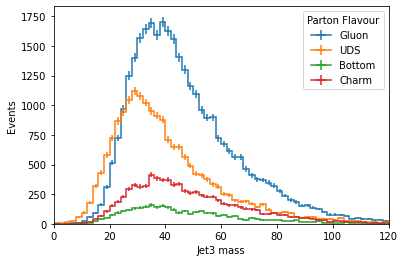

In [6]:

%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
hist.plot1d(result['mass3_g'])
hist.plot1d(result['mass3_uds'])
hist.plot1d(result['mass3_b'])
hist.plot1d(result['mass3_c'])
ax.set_xlabel("Jet3 mass")

<AxesSubplot:xlabel='Jet Mass', ylabel='Events'>

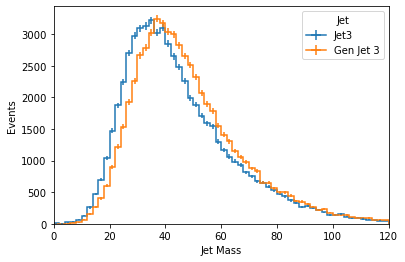

In [7]:
hist.plot1d(result['mass3'])
hist.plot1d(result['genmass3'])

In [8]:
print(events.btagWeight)

[{CSVV2: 0.687, DeepCSVB: 0.79}, {CSVV2: 1.15, ... {CSVV2: 0.975, DeepCSVB: 1.17}]


In [9]:
print(events.FatJet.fields)
print(events.Generator.fields)

['area', 'btagCSVV2', 'btagDDBvLV2', 'btagDDCvBV2', 'btagDDCvLV2', 'btagDeepB', 'btagHbb', 'deepTagMD_H4qvsQCD', 'deepTagMD_HbbvsQCD', 'deepTagMD_TvsQCD', 'deepTagMD_WvsQCD', 'deepTagMD_ZHbbvsQCD', 'deepTagMD_ZHccvsQCD', 'deepTagMD_ZbbvsQCD', 'deepTagMD_ZvsQCD', 'deepTagMD_bbvsLight', 'deepTagMD_ccvsLight', 'deepTag_H', 'deepTag_QCD', 'deepTag_QCDothers', 'deepTag_TvsQCD', 'deepTag_WvsQCD', 'deepTag_ZvsQCD', 'eta', 'mass', 'msoftdrop', 'n2b1', 'n3b1', 'particleNetMD_QCD', 'particleNetMD_Xbb', 'particleNetMD_Xcc', 'particleNetMD_Xqq', 'particleNet_H4qvsQCD', 'particleNet_HbbvsQCD', 'particleNet_HccvsQCD', 'particleNet_QCD', 'particleNet_TvsQCD', 'particleNet_WvsQCD', 'particleNet_ZvsQCD', 'particleNet_mass', 'phi', 'pt', 'rawFactor', 'tau1', 'tau2', 'tau3', 'tau4', 'lsf3', 'jetId', 'subJetIdx1', 'subJetIdx2', 'electronIdx3SJ', 'muonIdx3SJ', 'nConstituents', 'genJetAK8Idx', 'hadronFlavour', 'nBHadrons', 'nCHadrons', 'genJetAK8IdxG', 'subJetIdx1G', 'subJetIdx2G', 'subJetIdxG']
['binvar', 

In [10]:
#plot pt, eta, phi, fake rate, pt efficiency, gluon purity for difference selections with b tags for all jets 
#and each individual jet in the 3 jets